In [ ]:
#importing necessary libraries
import numpy as np
import utils
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import mean_squared_error
import random

In [2]:
def START_seed():
    seed = 9
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## -------------------------------------------------------------------------
# Plant B:

In [ ]:
#importing the data from the excel file and chooses needed data
df_b = pd.read_excel('data/plants_data.xlsx', sheet_name='Plant B', usecols='A:F', skiprows=1, nrows=1239)

df_b.drop(index=df_b.index[0], inplace=True)
df_b.drop(columns=['Date'], inplace=True)

rows, cols = df_b.shape
reaction_rates = [col for col in df_b.columns if " RR" in col]

print("Number of Columns:", cols, ", Number of Rows:", rows)

df_b.head()

In [ ]:
# Give assumption of fully optimized outputs
for rate in reaction_rates:
    df_b[rate[:-3]] = df_b[rate[:-3]] / df_b[rate]

## -------------------------------------------------------------------------
# Plant X:

### Data Loading and Preprocessing

In [3]:
# Uploading data and observing basic information
df_x = pd.read_excel('plants_data.xlsx', sheet_name='Plant X', usecols='A:L', skiprows=1, nrows=1239)

df_x.drop(index=df_x.index[0], inplace=True)
df_x.drop(columns=['Date'], inplace=True)

rows, cols = df_x.shape
reaction_rates = [col for col in df_x.columns if " RR" in col]

print("Number of Columns:", cols, ", Number of Rows:", rows)
df_x.head()

Number of Columns: 11 , Number of Rows: 1236


,Feed B,Feed S,Feed i,C1 RR,C1,NGL RR,NGL,Condensate RR,Condensate,Sulphur RR,Sulphur
1,99,407,106.0,1.0,645,1.0,2965,1.0,15090,1.0,1390
2,167,336,113.0,1.0,632,1.0,3316,1.0,15541,1.0,1377
3,176,418,118.0,1.0,640,1.0,3367,1.0,14088,1.0,1384
4,182,398,142.0,1.0,633,1.0,3500,1.0,10628,1.0,1328
5,186,455,142.0,1.0,622,1.0,3410,1.0,9631,1.0,1299


In [ ]:
# Give assumption of fully optimized outputs
for rate in reaction_rates:
    df_x[rate[:-3]] = df_x[rate[:-3]] / df_x[rate]

In [5]:
# data pre-processing
cols = list(set(df_x.columns) - set(reaction_rates))
df = df_x.copy()

df = utils.rm_zeros(df, cols)
df = utils.rm_outliers(df, n_neighbors=10, contamination=0.05)

df = df[cols] * 1.0

for i in cols:
    df[i] = pd.to_numeric(df[i], errors='coerce')
# NOTE: removeing outliers 1: only for output, 2: increase range

In [ ]:
# Save data for exploration
df.to_excel('processed_x.xlsx', index=False)

In [7]:
df.head()

,Sulphur,Condensate,Feed i,Feed S,Feed B,C1,NGL
1,1390.0,15090.0,106.0,407.0,99.0,645.0,2965.0
2,1377.0,15541.0,113.0,336.0,167.0,632.0,3316.0
3,1384.0,14088.0,118.0,418.0,176.0,640.0,3367.0
4,1328.0,10628.0,142.0,398.0,182.0,633.0,3500.0
5,1299.0,9631.0,142.0,455.0,186.0,622.0,3410.0


In [8]:
#evaluate different models on different with regard to differnet outcome
cols = ['Feed B', 'Feed S', 'Feed i']
C1_models , C1_results = utils.evaluate_models(df,['C1'], cols)
NGL_models , NGL_results = utils.evaluate_models(df,['NGL'], cols)
Condensate_models , Condensate_results = utils.evaluate_models(df,['Condensate'], cols)
Sulphur_models , Sulphur_results = utils.evaluate_models(df,['Sulphur'],cols)

===================== Results for =====================
output Streams = C1
                          R2 Score          MSE       RMSE        MAE  \
Linear Regression         0.252319  2055.686968  45.339684  29.540222   
Decision Tree            -0.368370  3762.218905  61.336929  26.786070   
Random Forest             0.445544  1524.429964  39.043949  18.943292   
Support Vector Regressor  0.027026  2675.111101  51.721476  20.413380   

                             CMAPE  
Linear Regression         0.945723  
Decision Tree             0.950130  
Random Forest             0.965681  
Support Vector Regressor  0.955456   

===================== Results for =====================
output Streams = NGL
                          R2 Score            MSE        RMSE         MAE  \
Linear Regression         0.334751  396248.921421  629.483059  556.459230   
Decision Tree             0.084869  545088.299453  738.300955  508.904209   
Random Forest             0.391015  362735.671682  602.275412  

In [9]:
cols = ['Feed i', 'Feed S']
Condensate_models_reqFeed , Condensate_results_reqFeed = utils.evaluate_models(df,['Condensate'], cols)

cols = ['Feed i', 'Feed S']
Sulphur_models_reqFeed , Sulphur_results_reqFeed = utils.evaluate_models(df,['Sulphur'],cols)

===================== Results for =====================
output Streams = Condensate
                          R2 Score           MSE         RMSE          MAE  \
Linear Regression         0.105371  1.038846e+07  3223.112983  2695.522513   
Decision Tree            -0.926393  2.236934e+07  4729.623256  3650.407960   
Random Forest            -0.011213  1.174223e+07  3426.693700  2686.556653   
Support Vector Regressor  0.000892  1.160168e+07  3406.123366  2819.143542   

                             CMAPE  
Linear Regression         0.828566  
Decision Tree             0.769221  
Random Forest             0.827693  
Support Vector Regressor  0.817822   

===================== Results for =====================
output Streams = Sulphur
                          R2 Score           MSE        RMSE         MAE  \
Linear Regression         0.234746  15414.994511  124.157136   88.422713   
Decision Tree            -0.433688  28879.669154  169.940193  111.636816   
Random Forest             0.1

In [10]:
features = ['Feed B', 'Feed i', 'Feed S']
targets = ['C1','NGL', 'Condensate', 'Sulphur']
all_models , all_results = utils.evaluate_models(df,targets,features)

===================== Results for =====================
output Streams = C1, NGL, Condensate, Sulphur
                          R2 Score           MSE         RMSE         MAE  \
Linear Regression         0.257110  2.680740e+06  1637.296547  838.231553   
Decision Tree            -0.106944  4.952340e+06  2225.385345  980.820481   
Random Forest             0.371632  2.527664e+06  1589.862805  731.611591   
Support Vector Regressor  0.026689  3.065391e+06  1750.825711  878.200152   

                             CMAPE  
Linear Regression         0.889622  
Decision Tree             0.885372  
Random Forest             0.908522  
Support Vector Regressor  0.887111   



In [11]:
features = ['Feed B', 'Feed i', 'Feed S']
targets = ['C1','NGL', 'Sulphur']
all_models_no_cond , all_results_no_cond = utils.evaluate_models(df,targets,features)

===================== Results for =====================
output Streams = C1, NGL, Sulphur
                          R2 Score            MSE        RMSE         MAE  \
Linear Regression         0.305470  137271.371544  370.501514  223.274638   
Decision Tree            -0.096931  198183.992922  445.178608  217.357051   
Random Forest             0.422581  127446.722757  356.996811  187.129199   
Support Vector Regressor  0.035506  217435.275535  466.299556  230.922866   

                             CMAPE  
Linear Regression         0.909814  
Decision Tree             0.911425  
Random Forest             0.928210  
Support Vector Regressor  0.910229   



In [12]:
coefficients, biases = utils.parameter_extractor(all_models_no_cond['Linear Regression'],['C1','NGL', 'Sulphur'])

LinearRegression()
LinearRegression()
LinearRegression()


### Prediction with Neural Network


Fold 1/5
Epoch [100/1000], Training Loss: 71763296.0000, Validation Loss: 73493016.0000, CMAPE: 9.34%, R²: -0.6623
Epoch [200/1000], Training Loss: 62307384.0000, Validation Loss: 63659748.0000, CMAPE: 50.95%, R²: -0.4399
Epoch [300/1000], Training Loss: 40903708.0000, Validation Loss: 41599116.0000, CMAPE: 68.42%, R²: 0.0591
Epoch [400/1000], Training Loss: 17804416.0000, Validation Loss: 17858886.0000, CMAPE: 76.13%, R²: 0.5961
Epoch [500/1000], Training Loss: 5420274.5000, Validation Loss: 5153842.5000, CMAPE: 84.98%, R²: 0.8834
Epoch [600/1000], Training Loss: 3664558.0000, Validation Loss: 3304383.7500, CMAPE: 86.33%, R²: 0.9253
Epoch [700/1000], Training Loss: 3600387.2500, Validation Loss: 3219335.0000, CMAPE: 86.37%, R²: 0.9272
Epoch [800/1000], Training Loss: 3586827.5000, Validation Loss: 3201694.0000, CMAPE: 86.36%, R²: 0.9276
Epoch [900/1000], Training Loss: 3574470.2500, Validation Loss: 3187002.0000, CMAPE: 86.35%, R²: 0.9279
Epoch [1000/1000], Training Loss: 3563058.000

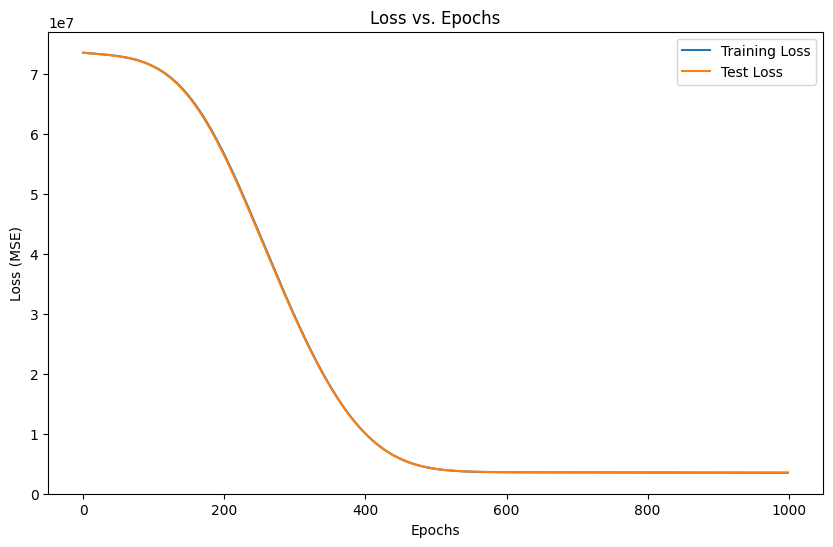

In [13]:
# NOTE: weight of internsically higherr value feed on loss, try normalization
input = [ 'Feed B','Feed S', 'Feed i']
output = ['NGL', 'C1', 'Condensate', 'Sulphur']
hidden_sizes = [12,12]

fnn, criterion, optimizer = utils.makeNN(input, output, hidden_sizes, df)
models, fold_results, trainLoss, valLoss = utils.trainKfolds(fnn, criterion, optimizer, epochs=1000, n_splits=5)
utils.loss_plot(trainLoss, valLoss)


Fold 1/5
Epoch [100/1000], Training Loss: 5063769.5000, Validation Loss: 5165354.5000, CMAPE: 8.49%, R²: -1.4233
Epoch [200/1000], Training Loss: 1951184.6250, Validation Loss: 1976880.0000, CMAPE: 56.57%, R²: 0.0726
Epoch [300/1000], Training Loss: 237358.9219, Validation Loss: 249026.4219, CMAPE: 85.95%, R²: 0.8832
Epoch [400/1000], Training Loss: 187802.6719, Validation Loss: 196739.5781, CMAPE: 87.56%, R²: 0.9077
Epoch [500/1000], Training Loss: 183971.3438, Validation Loss: 191377.0938, CMAPE: 87.65%, R²: 0.9102
Epoch [600/1000], Training Loss: 180390.2500, Validation Loss: 186347.4844, CMAPE: 87.73%, R²: 0.9126
Epoch [700/1000], Training Loss: 177161.9375, Validation Loss: 181747.1875, CMAPE: 87.78%, R²: 0.9147
Epoch [800/1000], Training Loss: 174353.1406, Validation Loss: 177671.3594, CMAPE: 87.79%, R²: 0.9166
Epoch [900/1000], Training Loss: 171988.8438, Validation Loss: 174161.8281, CMAPE: 87.77%, R²: 0.9183
Epoch [1000/1000], Training Loss: 170060.8438, Validation Loss: 1712

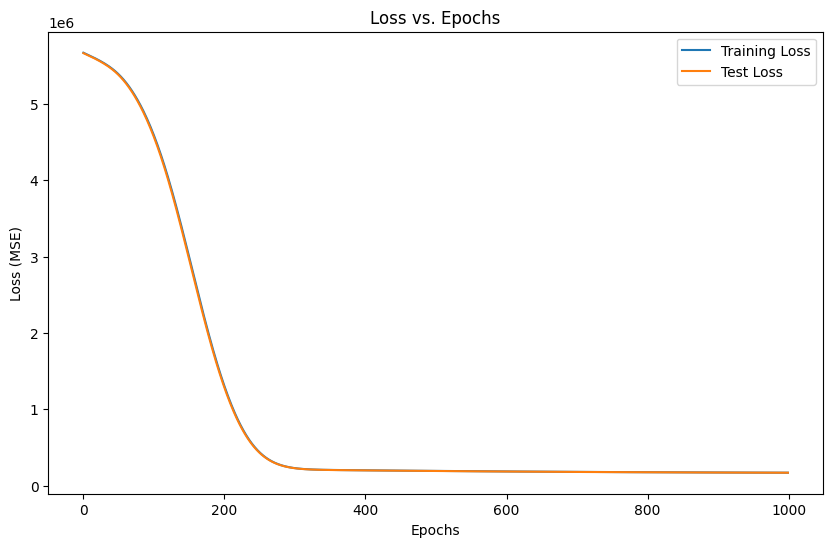

In [14]:
input = [ 'Feed B','Feed S', 'Feed i']
output = ['NGL', 'C1', 'Sulphur']
hidden_sizes = [12,12]

fnn, criterion, optimizer = utils.makeNN(input, output, hidden_sizes, df)
models, fold_results, trainLoss, valLoss = utils.trainKfolds(fnn, criterion, optimizer, epochs=1000, n_splits=5)
utils.loss_plot(trainLoss, valLoss)


Fold 1/5
Epoch [100/1000], Training Loss: 5516207.0000, Validation Loss: 5633176.0000, CMAPE: 0.99%, R²: -1.6428
Epoch [200/1000], Training Loss: 4805383.5000, Validation Loss: 4901913.5000, CMAPE: 12.59%, R²: -1.2997
Epoch [300/1000], Training Loss: 3203948.2500, Validation Loss: 3265423.2500, CMAPE: 46.99%, R²: -0.5319
Epoch [400/1000], Training Loss: 1415916.0000, Validation Loss: 1447001.3750, CMAPE: 75.10%, R²: 0.3212
Epoch [500/1000], Training Loss: 412233.6250, Validation Loss: 429688.4062, CMAPE: 85.71%, R²: 0.7984
Epoch [600/1000], Training Loss: 191162.0625, Validation Loss: 205201.6562, CMAPE: 89.70%, R²: 0.9037
Epoch [700/1000], Training Loss: 178323.0938, Validation Loss: 191247.6094, CMAPE: 89.75%, R²: 0.9103
Epoch [800/1000], Training Loss: 177051.8438, Validation Loss: 189659.0625, CMAPE: 89.74%, R²: 0.9110
Epoch [900/1000], Training Loss: 175883.4844, Validation Loss: 188296.5938, CMAPE: 89.75%, R²: 0.9117
Epoch [1000/1000], Training Loss: 174662.4219, Validation Loss

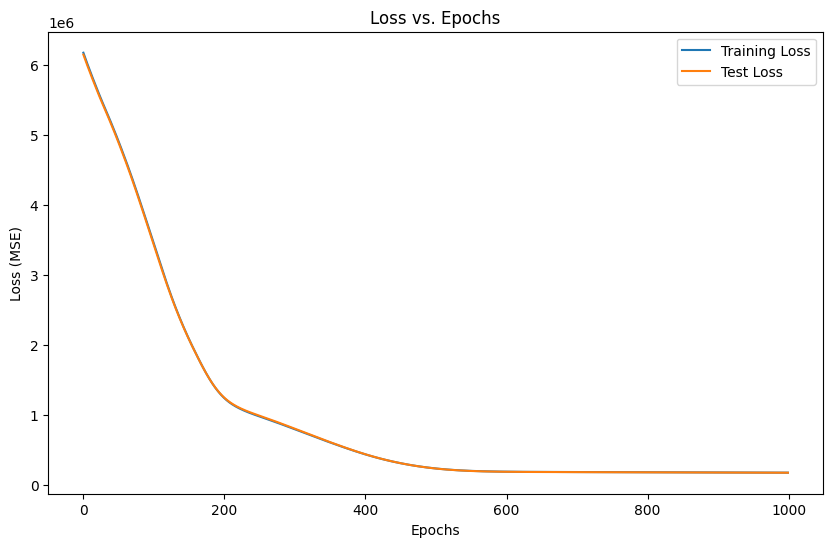

In [15]:
input = [ 'Feed B','Feed S', 'Feed i']
output = ['NGL', 'C1', 'Sulphur']
hidden_sizes = [3,8,16]

fnn, criterion, optimizer = utils.makeNN(input, output, hidden_sizes, df,coefficients = coefficients, biases= biases)

models, fold_results, trainLoss, valLoss = utils.trainKfolds(fnn, criterion, optimizer, epochs=1000, n_splits=5)
utils.loss_plot(trainLoss, valLoss)

In [16]:
input = [ 'Feed B','Feed S', 'Feed i']
output = ['NGL', 'C1', 'Condensate', 'Sulphur']

Dlosses_train = []
Dlosses_test = []
for d in np.arange(2, 20):    
    hidden_sizes = np.full(d, 4)

    fnn, criterion, optimizer = utils.makeNN(input, output, hidden_sizes,df)
    models, fold_results, trainLoss, valLoss = utils.trainKfolds(fnn, criterion, optimizer, epochs=1000, n_splits=5, printOut=0)

    Dlosses_train.append(np.mean(trainLoss[-10:]))
    Dlosses_test.append(np.mean(valLoss[-10:])) 

Wlosses_train = []
Wlosses_test = []
for w in np.arange(2, 20):    
    hidden_sizes = np.full(4, w)

    fnn, criterion, optimizer = utils.makeNN(input, output, hidden_sizes,df)
    models, fold_results, trainLoss, valLoss = utils.trainKfolds(fnn, criterion, optimizer, epochs=1000, n_splits=5, printOut=0)

    Wlosses_train.append(np.mean(trainLoss[-10:]))
    Wlosses_test.append(np.mean(valLoss[-10:]))


Fold 1/5
Fold 1 Validation Loss: 3610694.0000, CMAPE: 85.81%, R²: 0.9183

Fold 2/5
Fold 2 Validation Loss: 4161146.0000, CMAPE: 85.96%, R²: 0.9034

Fold 3/5
Fold 3 Validation Loss: 3454950.7500, CMAPE: 85.26%, R²: 0.9162

Fold 4/5
Fold 4 Validation Loss: 3808062.0000, CMAPE: 86.09%, R²: 0.9118

Fold 5/5
Fold 5 Validation Loss: 3917051.5000, CMAPE: 84.66%, R²: 0.9126

Average Validation Loss: 3790380.8500, Average CMAPE: 85.56%, Average R²: 0.9125

Fold 1/5
Fold 1 Validation Loss: 3376320.7500, CMAPE: 85.80%, R²: 0.9236

Fold 2/5
Fold 2 Validation Loss: 4111736.7500, CMAPE: 85.95%, R²: 0.9046

Fold 3/5
Fold 3 Validation Loss: 2993984.2500, CMAPE: 86.26%, R²: 0.9274

Fold 4/5
Fold 4 Validation Loss: 3807011.2500, CMAPE: 85.84%, R²: 0.9118

Fold 5/5
Fold 5 Validation Loss: 3459893.5000, CMAPE: 84.83%, R²: 0.9228

Average Validation Loss: 3549789.3000, Average CMAPE: 85.74%, Average R²: 0.9181

Fold 1/5
Fold 1 Validation Loss: 3095317.7500, CMAPE: 86.11%, R²: 0.9300

Fold 2/5
Fold 2 Valid

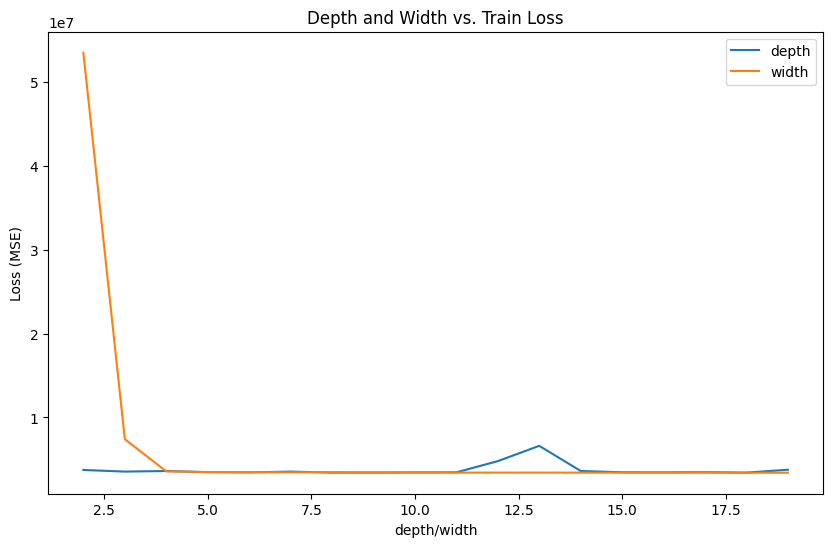

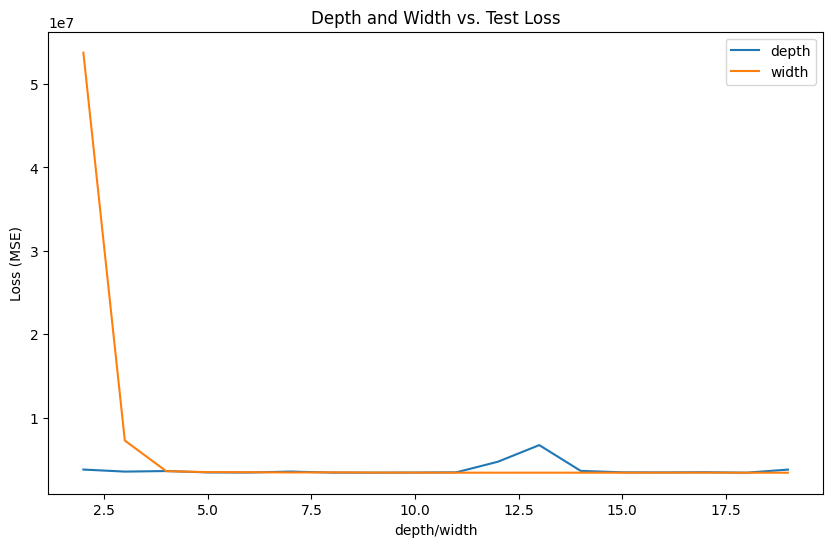

In [17]:
start = 0
plt.figure(figsize=(10, 6))
plt.plot(range(2+start,20), Dlosses_train[start:], label='depth')
plt.plot(range(2+start,20), Wlosses_train[start:], label='width')
plt.xlabel('depth/width')
plt.ylabel('Loss (MSE)')
plt.title('Depth and Width vs. Train Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(range(2+start,20), Dlosses_test[start:], label='depth')
plt.plot(range(2+start,20), Wlosses_test[start:], label='width')
plt.xlabel('depth/width')
plt.ylabel('Loss (MSE)')
plt.title('Depth and Width vs. Test Loss')
plt.legend()
plt.show()


Fold 1/5
Epoch [100/1000], Training Loss: 73283672.0000, Validation Loss: 75083504.0000, CMAPE: 0.02%, R²: -0.6983
Epoch [200/1000], Training Loss: 73280360.0000, Validation Loss: 75080136.0000, CMAPE: 0.04%, R²: -0.6982
Epoch [300/1000], Training Loss: 73271152.0000, Validation Loss: 75070408.0000, CMAPE: 0.12%, R²: -0.6980
Epoch [400/1000], Training Loss: 71218920.0000, Validation Loss: 72866080.0000, CMAPE: 16.92%, R²: -0.6481
Epoch [500/1000], Training Loss: 30253864.0000, Validation Loss: 30378078.0000, CMAPE: -131.01%, R²: 0.3129
Epoch [600/1000], Training Loss: 7457222.5000, Validation Loss: 7107111.5000, CMAPE: -47.61%, R²: 0.8392
Epoch [700/1000], Training Loss: 3941569.2500, Validation Loss: 3524221.2500, CMAPE: 40.03%, R²: 0.9203
Epoch [800/1000], Training Loss: 3559848.0000, Validation Loss: 3133036.2500, CMAPE: 73.04%, R²: 0.9291
Epoch [900/1000], Training Loss: 3518127.2500, Validation Loss: 3091062.2500, CMAPE: 83.46%, R²: 0.9301
Epoch [1000/1000], Training Loss: 351057

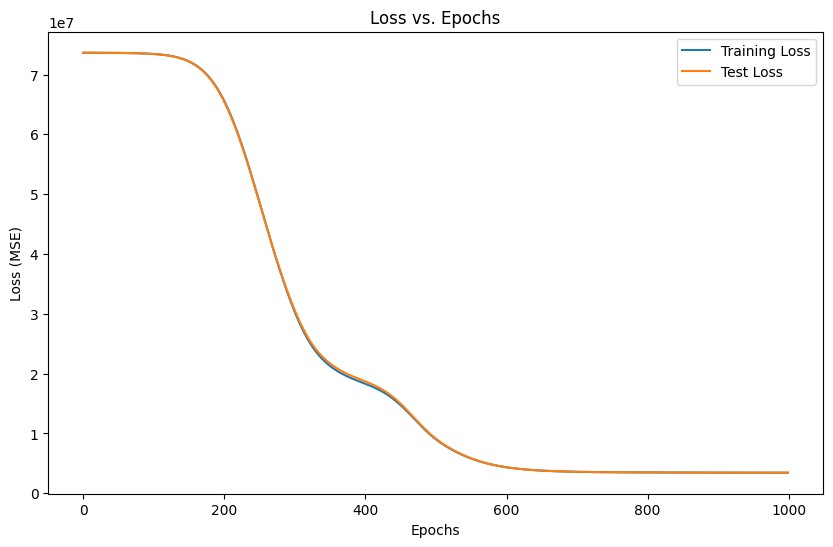

In [18]:
input = [ 'Feed B','Feed S', 'Feed i']
output = ['NGL', 'C1', 'Condensate', 'Sulphur']
hidden_sizes = np.full(5, 5)

fnn, criterion, optimizer = utils.makeNN(input, output, hidden_sizes,df)
models, fold_results, trainLoss, valLoss = utils.trainKfolds(fnn, criterion, optimizer, epochs=1000, n_splits=5)

utils.loss_plot(trainLoss, valLoss)

# Plant Y:
## -------------------------------------------------------------------------

### Data Loading and Pre-processing

In [19]:
# Uploading data and observing basic information
df_y = pd.read_excel('plants_data.xlsx', sheet_name='Plant Y', usecols='A:M', skiprows=1, nrows=1239)

df_y.drop(index=df_y.index[0], inplace=True)
df_y.drop(columns=['Date'], inplace=True)

rows, cols = df_y.shape
reaction_rates = [col for col in df_y.columns if " RR" in col]

print("Number of Columns:", cols, ", Number of Rows:", rows)
df_y.head()

Number of Columns: 12 , Number of Rows: 1236


,Feed B,Feed S,Feed k,Feed i,Feed O,Feed N,C1 RR,C1,NGL RR,NGL,Sulphur RR,Sulphur
1,299,178,73,797,139,114,1.0,1211,0.95,9494,1.0,2658
2,299,183,69,758,139,134,1.0,1202,0.95,9687,1.0,2395
3,299,184,86,769,179,115,1.0,1198,0.95,9742,1.0,2344
4,299,186,69,749,199,117,1.0,1191,0.95,10048,1.0,2409
5,299,185,76,667,197,122,1.0,1185,0.95,10053,1.0,2311


In [20]:
# Give assumption of fully optimized outputs
for rate in reaction_rates:
    df_y[rate[:-3]] = df_y[rate[:-3]] / df_y[rate]

In [21]:
# data pre-processing
cols = list(set(df_y.columns) - set(reaction_rates))
df = df_y.copy()

df = utils.rm_zeros(df, cols)
df = utils.rm_outliers(df, n_neighbors=10, contamination=0.05)

df = df[cols] * 1.0

for i in cols:
    df[i] = pd.to_numeric(df[i], errors='coerce')

In [22]:
df.to_excel('processed_y.xlsx', index=False)

In [23]:
df.head()

,Sulphur,Feed N,Feed k,Feed O,Feed i,Feed S,Feed B,C1,NGL
1,2658.0,114.0,73.0,139.0,797.0,178.0,299.0,1211.0,9993.684211
2,2395.0,134.0,69.0,139.0,758.0,183.0,299.0,1202.0,10196.842105
3,2344.0,115.0,86.0,179.0,769.0,184.0,299.0,1198.0,10254.736842
4,2409.0,117.0,69.0,199.0,749.0,186.0,299.0,1191.0,10576.842105
5,2311.0,122.0,76.0,197.0,667.0,185.0,299.0,1185.0,10582.105263


### Predict with Regression

In [24]:
cols = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
C1_models_y , C1_results_y = utils.evaluate_models(df,['C1'], cols)
NGL_models_y , NGL_results_y = utils.evaluate_models(df,['NGL'], cols)

cols = ['Feed B', 'Feed S','Feed i','Feed O ', 'Feed N']
Sulphur_models_y , Sulphur_results_y = utils.evaluate_models(df,['Sulphur'],cols)

===================== Results for =====================
output Streams = C1
                          R2 Score          MSE       RMSE        MAE  \
Linear Regression         0.241330  6713.834163  81.937990  53.143880   
Decision Tree             0.440342  4952.684211  70.375310  37.152047   
Random Forest             0.526734  4188.158613  64.715984  33.464620   
Support Vector Regressor  0.114696  7834.483720  88.512619  53.508432   

                             CMAPE  
Linear Regression         0.945459  
Decision Tree             0.961399  
Random Forest             0.964374  
Support Vector Regressor  0.943918   

===================== Results for =====================
output Streams = NGL
                          R2 Score           MSE         RMSE          MAE  \
Linear Regression         0.547594  1.010900e+06  1005.435290   682.437121   
Decision Tree             0.617242  8.552728e+05   924.809595   578.510311   
Random Forest             0.749887  5.588767e+05   747.58054

In [25]:
cols = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
out = ['C1', 'NGL', 'Sulphur']
all_models_y , all_results_y = utils.evaluate_models(df,out,cols)

===================== Results for =====================
output Streams = C1, NGL, Sulphur
                          R2 Score            MSE        RMSE         MAE  \
Linear Regression         0.402799  377322.393320  614.265735  331.390547   
Decision Tree             0.379479  323763.930689  569.002575  298.192675   
Random Forest             0.608564  224029.549665  473.317599  229.911770   
Support Vector Regressor  0.061735  830995.837160  911.589731  486.458536   

                             CMAPE  
Linear Regression         0.911435  
Decision Tree             0.913657  
Random Forest             0.932172  
Support Vector Regressor  0.883715   



### Neural Network


Fold 1/5
Epoch [200/2000], Training Loss: 21386482.0000, Validation Loss: 20840428.0000, CMAPE: 60.66%, R²: 0.2095
Epoch [400/2000], Training Loss: 806610.0000, Validation Loss: 1007551.2500, CMAPE: 84.60%, R²: 0.9618
Epoch [600/2000], Training Loss: 736028.2500, Validation Loss: 917575.1250, CMAPE: 84.75%, R²: 0.9652
Epoch [800/2000], Training Loss: 670227.9375, Validation Loss: 833354.0625, CMAPE: 84.89%, R²: 0.9684
Epoch [1000/2000], Training Loss: 613454.0625, Validation Loss: 760251.4375, CMAPE: 85.03%, R²: 0.9712
Epoch [1200/2000], Training Loss: 566529.1250, Validation Loss: 699904.9375, CMAPE: 85.16%, R²: 0.9735
Epoch [1400/2000], Training Loss: 528290.8125, Validation Loss: 651437.9375, CMAPE: 85.29%, R²: 0.9753
Epoch [1600/2000], Training Loss: 496824.8125, Validation Loss: 612806.3750, CMAPE: 85.44%, R²: 0.9768
Epoch [1800/2000], Training Loss: 470353.8750, Validation Loss: 581809.0625, CMAPE: 85.60%, R²: 0.9779
Epoch [2000/2000], Training Loss: 447648.1562, Validation Loss

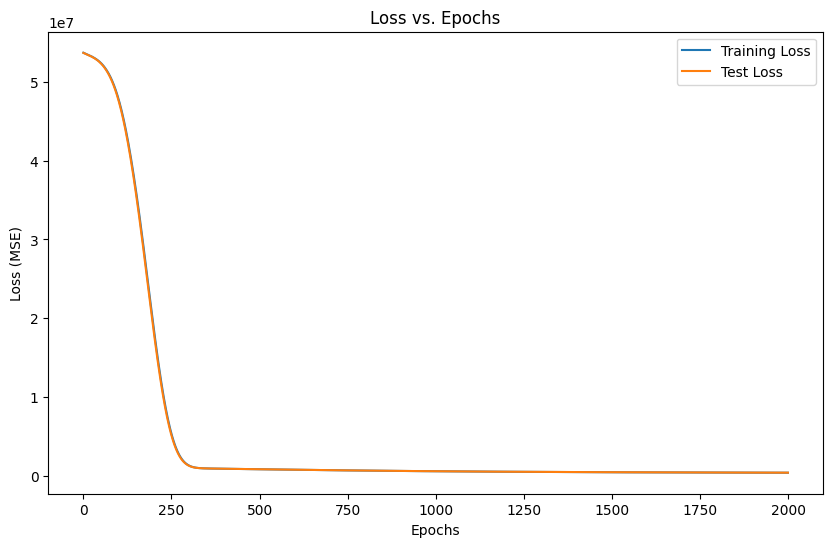

In [ ]:
input = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
output = ['C1', 'NGL', 'Sulphur']
hidden_sizes = [16,16]

fnn_y, criterion, optimizer = utils.makeNN(input, output, hidden_sizes,df)
models, fold_results, trainLoss, valLoss = utils.trainKfolds(fnn_y, criterion, optimizer, epochs=2000, n_splits=5)

utils.loss_plot(trainLoss, valLoss)

In [27]:
coefficients_y, biases_y = utils.parameter_extractor(all_models_y['Linear Regression'],['C1','NGL', 'Sulphur'])

LinearRegression()
LinearRegression()
LinearRegression()



Fold 1/5
Epoch [200/2000], Training Loss: 321664.3750, Validation Loss: 451315.9688, CMAPE: 86.79%, R²: 0.9829
Epoch [400/2000], Training Loss: 320438.0312, Validation Loss: 450415.7188, CMAPE: 86.85%, R²: 0.9829
Epoch [600/2000], Training Loss: 318960.9375, Validation Loss: 448431.1875, CMAPE: 86.91%, R²: 0.9830
Epoch [800/2000], Training Loss: 317295.7500, Validation Loss: 446187.9062, CMAPE: 87.00%, R²: 0.9831
Epoch [1000/2000], Training Loss: 315497.1250, Validation Loss: 443761.7812, CMAPE: 87.09%, R²: 0.9832
Epoch [1200/2000], Training Loss: 313578.1250, Validation Loss: 441175.5312, CMAPE: 87.20%, R²: 0.9833
Epoch [1400/2000], Training Loss: 311508.0625, Validation Loss: 438399.1250, CMAPE: 87.33%, R²: 0.9834
Epoch [1600/2000], Training Loss: 309203.6250, Validation Loss: 435333.5938, CMAPE: 87.49%, R²: 0.9835
Epoch [1800/2000], Training Loss: 306512.2188, Validation Loss: 431791.3125, CMAPE: 87.70%, R²: 0.9836
Epoch [2000/2000], Training Loss: 303187.0000, Validation Loss: 427

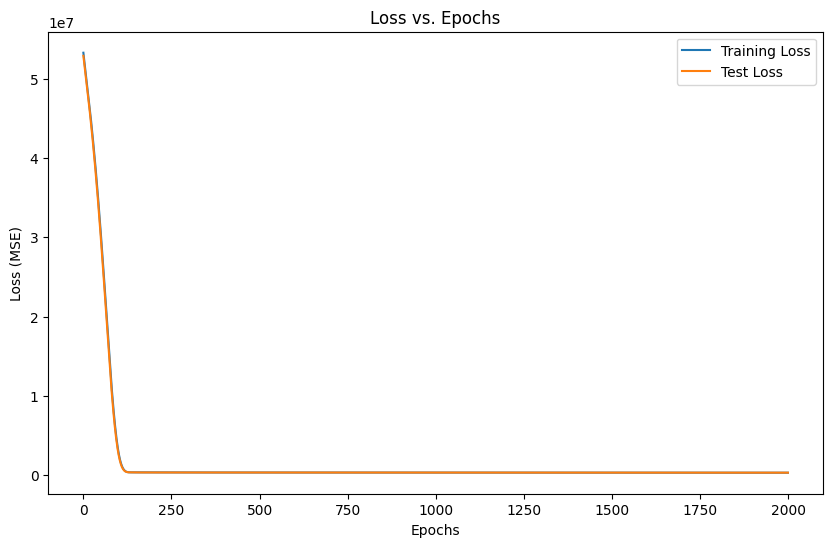

In [28]:
input = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
output = ['C1', 'NGL', 'Sulphur']
hidden_sizes = [3,16,16]

fnn_y, criterion, optimizer = utils.makeNN(input, output, hidden_sizes,df,coefficients=coefficients_y , biases=biases_y)
models_s, fold_results_s, trainLoss_S, valLoss_S = utils.trainKfolds(fnn_y, criterion, optimizer, epochs=2000, n_splits=5)

utils.loss_plot(trainLoss_S, valLoss_S)


Fold 1/5
Epoch [200/2000], Training Loss: 909249.0000, Validation Loss: 1160894.1250, CMAPE: 85.69%, R²: 0.9560
Epoch [400/2000], Training Loss: 698675.0625, Validation Loss: 891916.8125, CMAPE: 85.73%, R²: 0.9662
Epoch [600/2000], Training Loss: 573914.7500, Validation Loss: 723648.5000, CMAPE: 85.75%, R²: 0.9726
Epoch [800/2000], Training Loss: 511711.2812, Validation Loss: 636195.6875, CMAPE: 85.72%, R²: 0.9759
Epoch [1000/2000], Training Loss: 476881.2188, Validation Loss: 590315.5000, CMAPE: 85.79%, R²: 0.9776
Epoch [1200/2000], Training Loss: 450955.8750, Validation Loss: 561092.4375, CMAPE: 85.94%, R²: 0.9787
Epoch [1400/2000], Training Loss: 428830.5000, Validation Loss: 538497.8125, CMAPE: 86.17%, R²: 0.9796
Epoch [1600/2000], Training Loss: 406992.9375, Validation Loss: 515784.5312, CMAPE: 86.63%, R²: 0.9804
Epoch [1800/2000], Training Loss: 382071.4688, Validation Loss: 487146.8125, CMAPE: 87.60%, R²: 0.9815
Epoch [2000/2000], Training Loss: 361001.9062, Validation Loss: 46

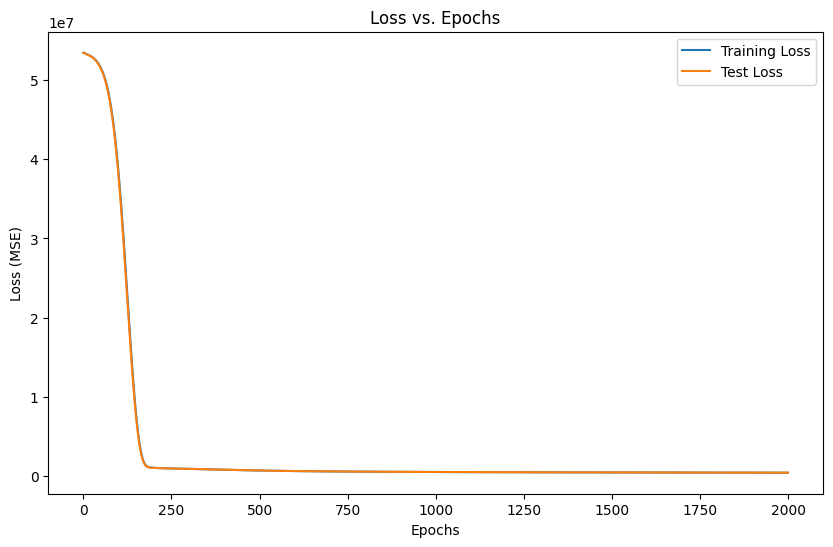

In [29]:
input = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
output = ['C1', 'NGL', 'Sulphur']
hidden_sizes = [16,16,16]

fnn_y, criterion, optimizer = utils.makeNN(input, output, hidden_sizes,df)
models_c, fold_results_c, trainLoss_c, valLoss_c = utils.trainKfolds(fnn_y, criterion, optimizer, epochs=2000, n_splits=5)

utils.loss_plot(trainLoss_c, valLoss_c)


Fold 1/5
Epoch [200/2000], Training Loss: 41938116.0000, Validation Loss: 41751460.0000, CMAPE: 40.85%, R²: -0.5836
Epoch [400/2000], Training Loss: 22023234.0000, Validation Loss: 21865456.0000, CMAPE: 65.12%, R²: 0.1707
Epoch [600/2000], Training Loss: 6801465.0000, Validation Loss: 6763088.5000, CMAPE: 77.51%, R²: 0.7435
Epoch [800/2000], Training Loss: 1493878.5000, Validation Loss: 1607715.3750, CMAPE: 84.50%, R²: 0.9390
Epoch [1000/2000], Training Loss: 766791.0625, Validation Loss: 947839.0625, CMAPE: 85.67%, R²: 0.9640
Epoch [1200/2000], Training Loss: 708278.8125, Validation Loss: 901243.0000, CMAPE: 85.78%, R²: 0.9658
Epoch [1400/2000], Training Loss: 684541.0000, Validation Loss: 873932.2500, CMAPE: 85.88%, R²: 0.9669
Epoch [1600/2000], Training Loss: 660775.0000, Validation Loss: 843603.5000, CMAPE: 85.99%, R²: 0.9680
Epoch [1800/2000], Training Loss: 636534.8125, Validation Loss: 812194.3750, CMAPE: 86.12%, R²: 0.9692
Epoch [2000/2000], Training Loss: 612205.9375, Validat

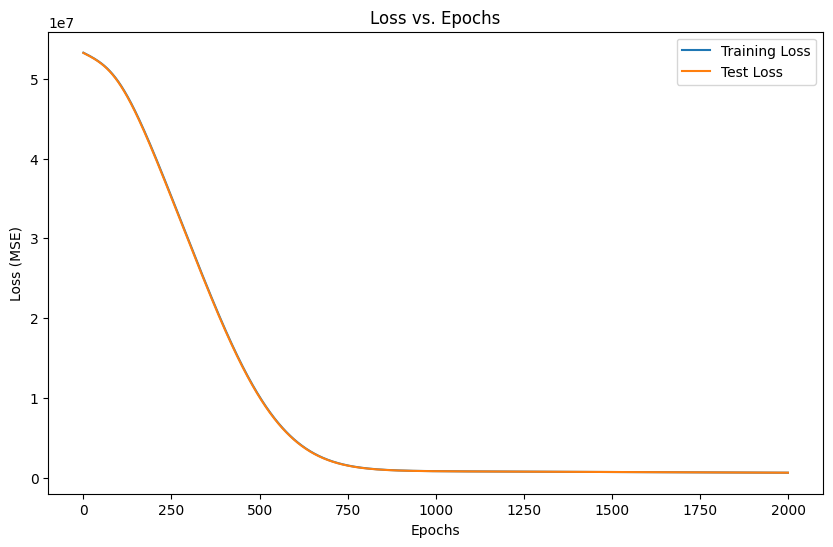

In [30]:
input = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
output = ['C1', 'NGL', 'Sulphur']
hidden_sizes = [16]

fnn_y, criterion, optimizer = utils.makeNN(input, output, hidden_sizes, df)
models, fold_results, trainLoss, valLoss = utils.trainKfolds(fnn_y, criterion, optimizer, epochs=2000, n_splits=5)

utils.loss_plot(trainLoss, valLoss)

In [31]:
# NOTE: set the fraction at start maybe
df_y_train = df.sample(frac=0.8, random_state=7)
df_y_test = df.drop(df_y_train.index)

In [32]:
input = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
output = ['C1']
hidden_sizes = [16,16]

fnn_y, criterion, optimizer = utils.makeNN(input, output, hidden_sizes,df_y_train)
models_C1, fold_results_C1, trainLoss_C1, valLoss_C1 = utils.trainKfolds(fnn_y, criterion, optimizer, epochs=2000, n_splits=5)


Fold 1/5
Epoch [200/2000], Training Loss: 22375.3633, Validation Loss: 16636.6250, CMAPE: 90.42%, R²: -2.0317
Epoch [400/2000], Training Loss: 14505.0225, Validation Loss: 11942.0527, CMAPE: 92.14%, R²: -1.1762
Epoch [600/2000], Training Loss: 12439.0215, Validation Loss: 9723.1592, CMAPE: 93.35%, R²: -0.7719
Epoch [800/2000], Training Loss: 11557.7783, Validation Loss: 8757.8154, CMAPE: 93.67%, R²: -0.5959
Epoch [1000/2000], Training Loss: 11073.4531, Validation Loss: 8213.6045, CMAPE: 93.78%, R²: -0.4968
Epoch [1200/2000], Training Loss: 10716.2695, Validation Loss: 7816.7417, CMAPE: 93.90%, R²: -0.4245
Epoch [1400/2000], Training Loss: 10264.1162, Validation Loss: 7262.0093, CMAPE: 94.11%, R²: -0.3234
Epoch [1600/2000], Training Loss: 9566.6338, Validation Loss: 6578.2866, CMAPE: 94.39%, R²: -0.1988
Epoch [1800/2000], Training Loss: 8866.7344, Validation Loss: 6199.8994, CMAPE: 94.59%, R²: -0.1298
Epoch [2000/2000], Training Loss: 8185.7739, Validation Loss: 5443.0767, CMAPE: 94.84

In [33]:
input = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
output = ['NGL']
hidden_sizes = [16,16]

fnn_y, criterion, optimizer = utils.makeNN(input, output, hidden_sizes,df_y_train)
models_NGL, fold_results_NGL, trainLoss_NGL, valLoss_NGL = utils.trainKfolds(fnn_y, criterion, optimizer, epochs=2000, n_splits=5)


Fold 1/5
Epoch [200/2000], Training Loss: 19662064.0000, Validation Loss: 18974848.0000, CMAPE: 66.55%, R²: -10.3604
Epoch [400/2000], Training Loss: 2093752.7500, Validation Loss: 1822523.1250, CMAPE: 90.88%, R²: -0.0912
Epoch [600/2000], Training Loss: 1755451.2500, Validation Loss: 1503643.1250, CMAPE: 91.76%, R²: 0.0998
Epoch [800/2000], Training Loss: 1500612.7500, Validation Loss: 1250674.6250, CMAPE: 92.55%, R²: 0.2512
Epoch [1000/2000], Training Loss: 1345349.3750, Validation Loss: 1083951.1250, CMAPE: 93.17%, R²: 0.3510
Epoch [1200/2000], Training Loss: 1242509.0000, Validation Loss: 967885.8750, CMAPE: 93.67%, R²: 0.4205
Epoch [1400/2000], Training Loss: 1160239.6250, Validation Loss: 877425.3125, CMAPE: 94.04%, R²: 0.4747
Epoch [1600/2000], Training Loss: 1091250.6250, Validation Loss: 804475.8125, CMAPE: 94.29%, R²: 0.5184
Epoch [1800/2000], Training Loss: 1034987.8125, Validation Loss: 746947.2500, CMAPE: 94.46%, R²: 0.5528
Epoch [2000/2000], Training Loss: 991727.5625, V

In [34]:
input = ['Feed B', 'Feed S','Feed i','Feed O ', 'Feed N']
output = ['Sulphur']
hidden_sizes = [16,16]

fnn_y, criterion, optimizer = utils.makeNN(input, output, hidden_sizes,df_y_train)
models_Sulphur, fold_result_Sulphur, trainLoss_Sulphur, valLoss_Sulphur = utils.trainKfolds(fnn_y, criterion, optimizer, epochs=2000, n_splits=5)


Fold 1/5
Epoch [200/2000], Training Loss: 161251.3125, Validation Loss: 136694.2969, CMAPE: 86.43%, R²: 0.1198
Epoch [400/2000], Training Loss: 148804.9844, Validation Loss: 130624.6406, CMAPE: 86.73%, R²: 0.1589
Epoch [600/2000], Training Loss: 140305.3125, Validation Loss: 125896.2500, CMAPE: 86.96%, R²: 0.1893
Epoch [800/2000], Training Loss: 133913.1406, Validation Loss: 123348.1172, CMAPE: 87.14%, R²: 0.2057
Epoch [1000/2000], Training Loss: 129554.6094, Validation Loss: 122436.4531, CMAPE: 87.23%, R²: 0.2116
Epoch [1200/2000], Training Loss: 126989.1875, Validation Loss: 122610.9922, CMAPE: 87.21%, R²: 0.2105
Epoch [1400/2000], Training Loss: 125620.7344, Validation Loss: 123214.6562, CMAPE: 87.19%, R²: 0.2066
Epoch [1600/2000], Training Loss: 124844.8516, Validation Loss: 123752.4062, CMAPE: 87.18%, R²: 0.2031
Epoch [1800/2000], Training Loss: 124318.6953, Validation Loss: 124081.4766, CMAPE: 87.17%, R²: 0.2010
Epoch [2000/2000], Training Loss: 123917.7891, Validation Loss: 124

In [35]:
input = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
output = ['C1', 'NGL', 'Sulphur']
hidden_sizes = [16,16]

fnn_y, criterion, optimizer = utils.makeNN(input, output, hidden_sizes, df_y_train)
models_all, fold_results_all, trainLoss_all, valLoss_all = utils.trainKfolds(fnn_y, criterion, optimizer, epochs=2000, n_splits=5)


Fold 1/5
Epoch [200/2000], Training Loss: 14043156.0000, Validation Loss: 13675247.0000, CMAPE: 63.36%, R²: 0.4726
Epoch [400/2000], Training Loss: 629713.8125, Validation Loss: 532779.0625, CMAPE: 87.90%, R²: 0.9795
Epoch [600/2000], Training Loss: 589894.3125, Validation Loss: 494375.1562, CMAPE: 87.88%, R²: 0.9809
Epoch [800/2000], Training Loss: 555540.8125, Validation Loss: 460120.2188, CMAPE: 87.85%, R²: 0.9823
Epoch [1000/2000], Training Loss: 527989.7500, Validation Loss: 431613.1875, CMAPE: 87.85%, R²: 0.9834
Epoch [1200/2000], Training Loss: 506228.8750, Validation Loss: 408366.0625, CMAPE: 87.89%, R²: 0.9843
Epoch [1400/2000], Training Loss: 488539.5312, Validation Loss: 389183.3438, CMAPE: 87.96%, R²: 0.9850
Epoch [1600/2000], Training Loss: 473498.5625, Validation Loss: 372976.4375, CMAPE: 88.05%, R²: 0.9856
Epoch [1800/2000], Training Loss: 460278.8438, Validation Loss: 359026.3438, CMAPE: 88.16%, R²: 0.9862
Epoch [2000/2000], Training Loss: 448512.5938, Validation Loss:

In [ ]:
input = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
output = ['C1', 'NGL', 'Sulphur']
y_pred = utils.ensemble_predict(models_all, torch.tensor(df_y_test[input].values, dtype=torch.float32))
y_test = df_y_test[output].to_numpy()

MSE = mean_squared_error(y_test, y_pred)
MAP = 1 - np.mean(np.abs((y_test - y_pred) / y_test))

print(f'MSE: {MSE:.4f}, and CMAPE: {MAP:.4f}')

MSE: 435378.0545, and MAP: 0.8819


In [ ]:
input = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
output = ['C1']
y_pred = utils.ensemble_predict(models_C1, torch.tensor(df_y_test[input].values, dtype=torch.float32))
y_test = df_y_test[output].to_numpy()

MSE = mean_squared_error(y_test, y_pred)
MAP = 1 - np.mean(np.abs((y_test - y_pred) / y_test))

print(f'MSE: {MSE:.4f}, and CMAPE: {MAP:.4f}')

MSE: 6450.0188, and MAP: 0.9428


In [ ]:
input = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
output = ['NGL']
y_pred = utils.ensemble_predict(models_NGL, torch.tensor(df_y_test[input].values, dtype=torch.float32))
y_test = df_y_test[output].to_numpy()

MSE = mean_squared_error(y_test, y_pred)
MAP = 1 - np.mean(np.abs((y_test - y_pred) / y_test))

print(f'MSE: {MSE:.4f}, and CMAPE: {MAP:.4f}')

MSE: 996524.6069, and MAP: 0.9357


In [ ]:
input = ['Feed B', 'Feed S','Feed i','Feed O ', 'Feed N']
output = ['Sulphur']
y_pred = utils.ensemble_predict(models_Sulphur, torch.tensor(df_y_test[input].values, dtype=torch.float32))
y_test = df_y_test[output].to_numpy()

MSE = mean_squared_error(y_test, y_pred)
MAP = 1 - np.mean(np.abs((y_test - y_pred) / y_test))

print(f'MSE: {MSE:.4f}, and CMAPE: {MAP:.4f}')

MSE: 138524.7073, and MAP: 0.8597


In [40]:
inputs = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
output = ['C1', 'NGL', 'Sulphur']
# calculated theoritical yields: 

                    #   C1   NGL Sulphur
yieldsTheo = pd.DataFrame([[0.72, 7.80, 1.55], #B
                      [0.84, 2.00, 2.00], #S
                      [0.70, 9.47, 0.00], #K
                      [0.84, 2.49, 0.90], #i
                      [0.50, 23.4, 1.90], #O
                      [0.80, 6.67, 0.60]], #N
             columns=output, index=inputs) 

In [41]:
# fcartion of the entire df_y ins+outs (dataFrame)
# df_y_train
# df_y_test

input = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
output = ['C1', 'NGL', 'Sulphur']
df_y_test_in = df_y_test[input]
df_y_test_out = df_y_test[output]

In [42]:
predTheo = df_y_test_in.dot(yieldsTheo)

In [ ]:
MSE = mean_squared_error(df_y_test_out, predTheo)
MAP = 1 - np.mean(np.abs((df_y_test_out - predTheo) / df_y_test_out))

print(f'MSE: {MSE:.4f}, and CMAPE: {MAP:.4f}')

MSE: 2379365.9523, and MAP: 0.8266


In [44]:
# NOTE: the model used should not be trained on the fractioned test data, to be changed
cols = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
rows = ['C1', 'NGL', 'Sulphur']
yield_results, yield_std = utils.feedsYield (models_c, cols, rows, multipleModels = 1, constExp = [0,1000,2], feedRangeBounds = [0, 2000])
yield_results = yield_results.T

In [45]:
yield_results.head(6)

,C1,NGL,Sulphur
Feed B,0.865721,10.189064,1.737378
Feed S,0.703590,8.642305,1.383454
Feed k,-0.080299,-0.643197,-0.161354
Feed i,0.381396,3.667027,0.836720
Feed O,1.228957,14.380635,2.439803
Feed N,1.054156,12.120022,2.085818


In [46]:
yield_std.head(6)

,Feed B,Feed S,Feed k,Feed i,Feed O,Feed N
C1,0.001675,0.014006,0.030414,0.011803,0.020671,0.026717
NGL,0.025356,0.183635,0.261554,0.156738,0.270532,0.360628
Sulphur,0.002463,0.026996,0.061942,0.023720,0.039422,0.052566


In [47]:
predNN = df_y_test_in.dot(yield_results) 
MSE = mean_squared_error(df_y_test_out, predNN)
MAP = 1 - np.mean(np.abs((df_y_test_out -predNN) / df_y_test_out))

print(f'MSE: {MSE:.4f}, and MAP: {MAP:.4f}')

MSE: 446985.7086, and MAP: 0.8811


In [48]:
cols = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
rows = ['C1']
yield_results_C1, yield_std_C1 = utils.feedsYield (models_C1, cols, rows, multipleModels = 1, constExp = [0,1000,2], feedRangeBounds = [0, 2000])
yield_results_C1 = yield_results_C1.T

In [49]:
cols = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
rows = ['NGL']
yield_results_NGL, yield_std_NGL = utils.feedsYield (models_NGL, cols, rows, multipleModels = 1, constExp = [0,1000,2], feedRangeBounds = [0, 2000])
yield_results_NGL = yield_results_NGL.T

In [50]:
cols = ['Feed B', 'Feed S','Feed i','Feed O ', 'Feed N']
rows = ['Sulphur']
yield_results_Sulphur, yield_std_Sulphur = utils.feedsYield (models_Sulphur, cols, rows, multipleModels = 1, constExp = [0,1000,2], feedRangeBounds = [0, 2000])
yield_results_Sulphur = yield_results_Sulphur.T
yield_results_Sulphur.loc['Feed k'] = 0
yield_std_Sulphur['Feed k'] = -1

In [51]:
yield_new = pd.concat([yield_results_C1, yield_results_NGL, yield_results_Sulphur], axis=1)
yield_new.head(6)

,C1,NGL,Sulphur
Feed B,0.876961,9.918524,2.738686
Feed S,0.161728,9.262254,0.124818
Feed k,0.006614,2.265726,0.000000
Feed i,0.384648,3.509477,1.324432
Feed O,1.009994,12.102138,1.989636
Feed N,2.119871,12.072558,1.566658


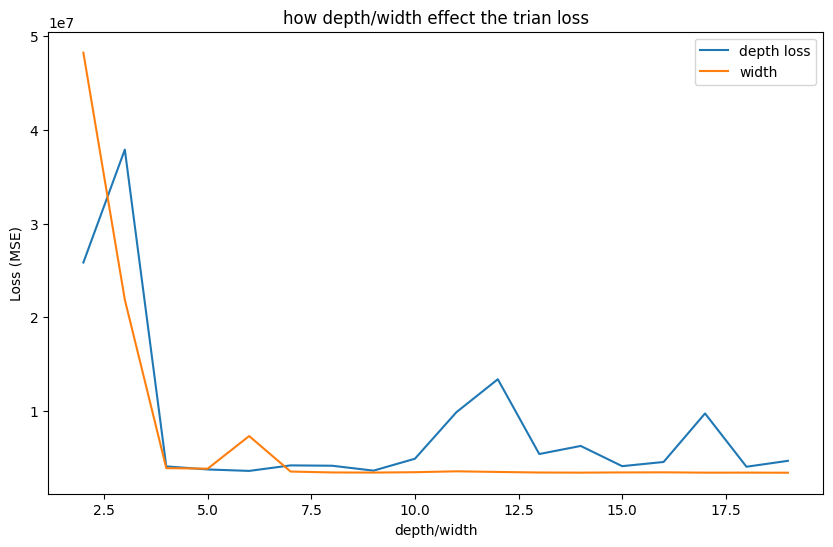

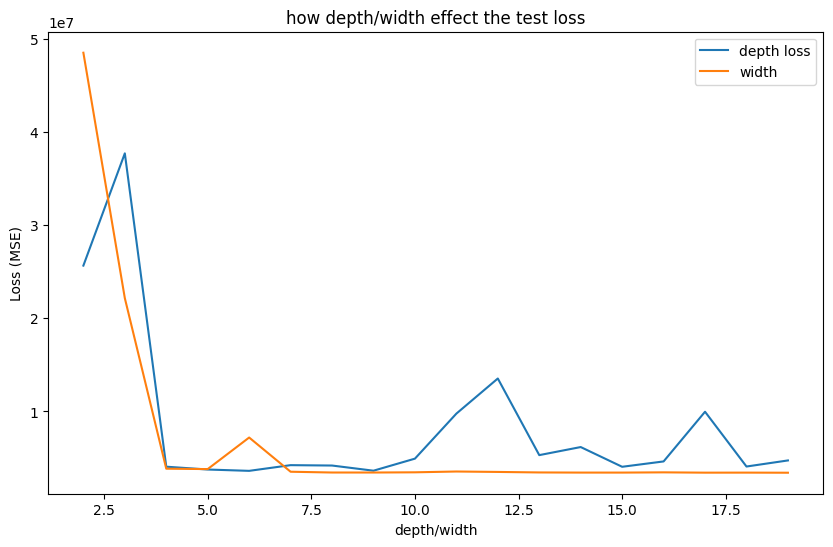

In [52]:
yield_std_new = pd.concat([yield_std_C1, yield_std_NGL, yield_std_Sulphur], axis=0).T
yield_std_new.head(6)

,C1,NGL,Sulphur
Feed B,0.160874,0.040372,0.136601
Feed S,0.105875,0.090337,0.175577
Feed k,0.100664,0.122088,-1.000000
Feed i,0.067002,0.099635,0.065900
Feed O,0.053159,0.325784,0.012279
Feed N,0.176972,0.228706,0.009673


In [ ]:
predNN_new = df_y_test_in.dot(yield_new) 
MSE = mean_squared_error(df_y_test_out, predNN_new)
MAP = 1 - np.mean(np.abs((df_y_test_out - predNN_new) / df_y_test_out))

print(f'MSE: {MSE:.4f}, and CMAPE: {MAP:.4f}')

MSE: 401879.7830, and MAP: 0.9026
